# Install package 

In [106]:
!pip install vnstock

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Prepair data

In [107]:
# "STB, VIC, SSI, MSN, FPT, HAG, KDC, EIB, DPM, VNM, REE, OGC, IJC, VCB, PNJ, BVH, ITA, HPG, CTG, SJS, QCG, PVF, PVD, CII, SBT, VSH, KDH, DIG, HVG, GMD".split(", ")

In [117]:
from vnstock import *
import pandas as pd
import numpy as np

# Tạo danh sách các mã cổ phiếu
tickers = ['QTP', 'DCM', 'DPM']
# Tải dữ liệu giá cổ phiếu từ Yahoo Finance
data = pd.DataFrame()
for ticker in tickers:
  try:
    df =  stock_historical_data(symbol=ticker, 
                                start_date="2019-01-01", 
                                end_date='2023-04-11')[['TradingDate', 'Close']]
    df.rename(columns={'Close': ticker}, inplace =True)
    df.set_index('TradingDate', inplace=True)
    data = pd.concat([data, df], axis=1)
  except Exception as e:
    print(ticker)

In [109]:
#save data
data.to_csv('stock_data.csv')

In [110]:
data.head()

,QTP,DCM,DHG
TradingDate,,,
2019-01-02,7200.0,7760.0,64469.0
2019-01-03,7200.0,7537.0,62185.0
2019-01-04,6600.0,7568.0,62185.0
2019-01-07,6600.0,7598.0,63454.0
2019-01-08,6600.0,7529.0,63284.0


# Optimal inventory theory


In [111]:
# Tính lợi nhuận kỳ vọng và độ lệch chuẩn của các tài sản
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [112]:
def portfolio_optimization(mean_returns, cov_matrix):
    num_assets = len(tickers)
    num_portfolios = 10000

    # Tạo danh sách chứa tất cả các trọng số của danh mục đầu tư
    weights_list = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_list.append(weights)

    # Tính toán lợi nhuận và độ lệch chuẩn của từng danh mục đầu tư
    portfolio_returns = []
    portfolio_volatilities = []
    for weights in weights_list:
        portfolio_returns.append(np.sum(mean_returns * weights))
        portfolio_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))
    portfolio_returns = np.array(portfolio_returns)
    portfolio_volatilities = np.array(portfolio_volatilities)

    # Tìm danh mục đầu tư tối ưu
    portfolio_sharpe_ratios = portfolio_returns / portfolio_volatilities
    max_sharpe_ratio_index = np.argmax(portfolio_sharpe_ratios)
    optimal_weights = weights_list[max_sharpe_ratio_index]

    return portfolio_returns, portfolio_volatilities, portfolio_sharpe_ratios, optimal_weights

# Tính toán đầu tư tối ưu
portfolio_returns, portfolio_volatilities, portfolio_sharpe_ratios, optimal_weights = portfolio_optimization(mean_returns, cov_matrix)

# In kết quả
print("Lợi nhuận kỳ vọng của danh mục đầu tư tối ưu: ", np.round(np.sum(mean_returns * optimal_weights) * 100, 2), "%")
print("Độ lệch chuẩn của danh mục đầu tư tối ưu: ", np.round(np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * 100, 2), "%")
print("Tỷ lệ phân bổ tài sản trong danh mục đầu tư tối ưu: ")
for i in range(len(tickers)):
    print(tickers[i] + ": ", np.round(optimal_weights[i] * 100, 2), "%")

Lợi nhuận kỳ vọng của danh mục đầu tư tối ưu:  0.1 %
Độ lệch chuẩn của danh mục đầu tư tối ưu:  1.6 %
Tỷ lệ phân bổ tài sản trong danh mục đầu tư tối ưu: 
QTP:  36.88 %
DCM:  39.57 %
DHG:  23.55 %


# Pair trading

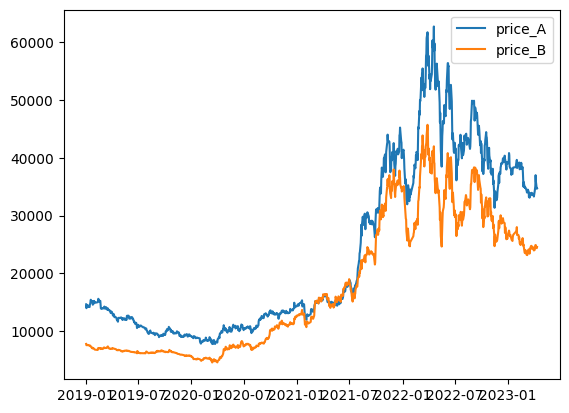

In [126]:
df = pd.DataFrame()
df['price_A'] = data['DPM']
df['price_B'] = data['DCM']
df['date'] = data.index

plt.plot(df['price_A'])
plt.plot(df['price_B'])

plt.legend(['price_A', 'price_B'])

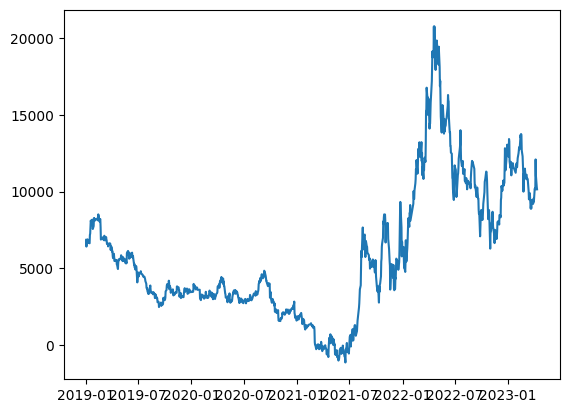

In [127]:
plt.plot(df['price_A']-df['price_B'])

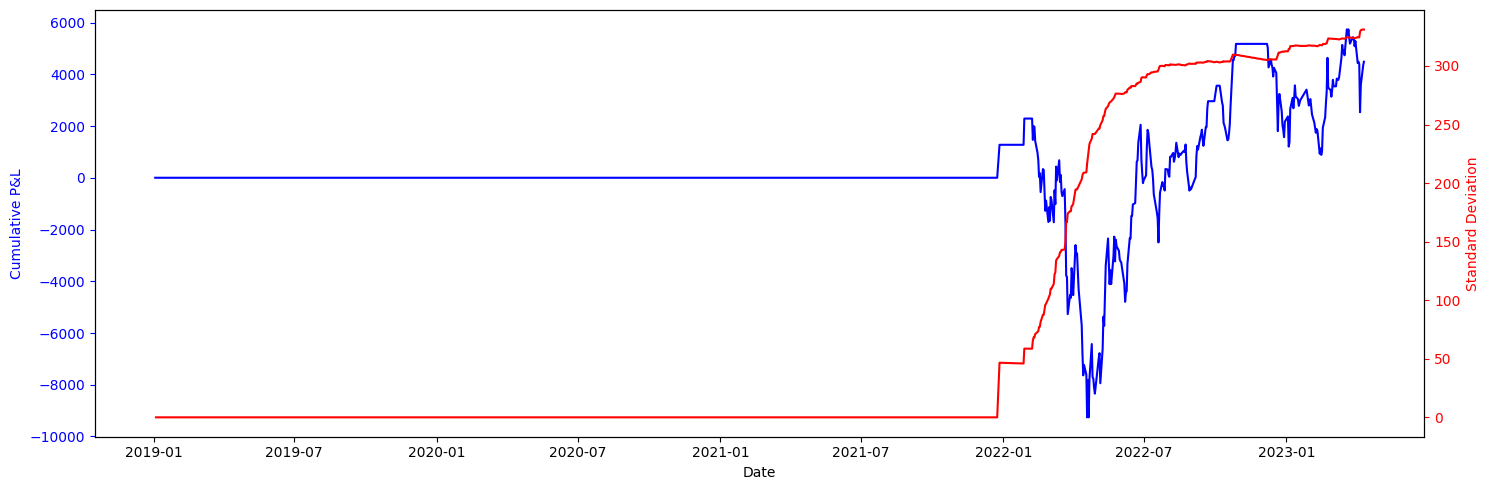

In [130]:
# Tính toán sự khác biệt giá của hai tài sản
df['diff'] = df['price_A'] - df['price_B']
df['A_return'] = df['price_A'].diff()
df['B_return'] = df['price_B'].diff()
df['returns'] = df['A_return'] - df['B_return']

# Xác định điểm vào lệnh khi sự khác biệt giá vượt qua ngưỡng xác định
threshold = 2 * df['diff'].std()
df['signal'] = (df['diff'] < -threshold).astype(int) - (df['diff'] > threshold).astype(int)

# Tính toán lợi nhuận và độ lệch chuẩn
df['pnl'] = df['signal'].shift(1) * df['returns']
df['cum_pnl'] = df['pnl'].cumsum()
df['std'] = df['pnl'].expanding().std()

# Vẽ biểu đồ lợi nhuận tích lũy và độ lệch chuẩn
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df['date'], df['cum_pnl'], 'b-')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative P&L', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(df['date'], df['std'], 'r-')
ax2.set_ylabel('Standard Deviation', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()
